In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks import SaveModelCallback
from functools import partial
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import re, os
import random
import fastai

In [23]:
raw_dir = Path("raw")
    
raws = [raw_path for raw_path in raw_dir.ls()]
images = sorted([raw_path for raw_path in raws if ".jpg" in raw_path.name])
masks = sorted([raw_path for raw_path in raws if "_mask" in raw_path.name])

processed_dir = Path("processed")
for f in processed_dir.ls(): os.remove(f)

In [24]:
from tqdm import tqdm
for image_path,mask_path in tqdm(zip(images,masks)):
    
    image = cv.imread(image_path.as_posix())
    
    padded = cv.copyMakeBorder(
        image, 0, 0,
        (image.shape[0] - image.shape[1])//2,
        (image.shape[0] - image.shape[1])//2,
        cv.BORDER_CONSTANT, value=(255,255,255)
    )
    padded = cv.resize(padded, None, fx=0.5, fy=0.5, interpolation = cv.INTER_CUBIC)
    padded_image_path = processed_dir/(image_path.stem + "_padded" + image_path.suffix)
    
    cv.imwrite(padded_image_path.as_posix(), padded)
    
    mask = cv.imread(mask_path.as_posix(), cv.COLOR_BGR2GRAY)
    mask[mask!=0]=1
    mask = cv.copyMakeBorder(
        mask, 0, 0,
        (mask.shape[0] - mask.shape[1])//2,
        (mask.shape[0] - mask.shape[1])//2,
        cv.BORDER_CONSTANT, value=(1,1,1)
    )
    mask = cv.resize(mask, None,fx=0.5,fy=0.5, interpolation = cv.INTER_CUBIC)
    processed_mask_path = processed_dir/(mask_path.stem + "_processed" + mask_path.suffix)
    cv.imwrite(processed_mask_path.as_posix(), mask)
    

7it [00:19,  2.71s/it]


# fastAI

In [25]:
transforms = get_transforms(
    do_flip = True,
    flip_vert = True,
    max_zoom = 1, #consider
    max_rotate = 0,
    max_lighting = None,
    max_warp = None,
    p_affine = 0.75,
    p_lighting = 0.75)

In [26]:
get_label_from_image = lambda path: re.sub(r'_padded.jpg', '_mask_processed.tif', path.as_posix())
codes = ["BRAIN", "NOT-BRAIN"]

bs = 6

src = (
    SegmentationItemList.from_folder(processed_dir)
    .filter_by_func(lambda fname:'padded' in Path(fname).name)
    .split_by_rand_pct(valid_pct=0.25, seed=2)
    .label_from_func(get_label_from_image, classes=codes)
)
data = (
    src.transform(transforms, tfm_y=True, size = 448)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [20]:
data

ImageDataBunch;

Train: LabelList (6 items)
x: SegmentationItemList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: SegmentationLabelList
ImageSegment (1, 448, 448),ImageSegment (1, 448, 448),ImageSegment (1, 448, 448),ImageSegment (1, 448, 448),ImageSegment (1, 448, 448)
Path: processed;

Valid: LabelList (1 items)
x: SegmentationItemList
Image (3, 448, 448)
y: SegmentationLabelList
ImageSegment (1, 448, 448)
Path: processed;

Test: None

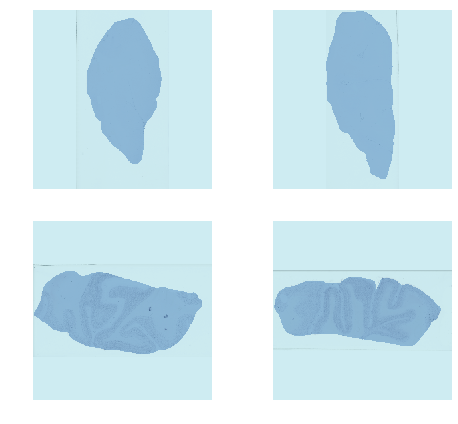

In [27]:
data.show_batch(rows=2, figsize=(7,6))

In [28]:
learn = unet_learner(
    data,
    models.resnet34,
    metrics=partial(dice, iou=True),
    model_dir='..')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-05
Min loss divided by 10: 1.45E-04


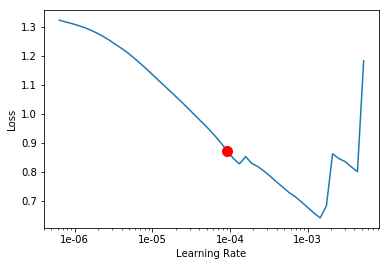

In [29]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [30]:
lr = 5e-04
learn.fit_one_cycle(cyc_len = 20,
                    callbacks =[SaveModelCallback(
                        learn,
                        every='improvement',
                        monitor = 'dice',
                        name='best-stage1')],
                    max_lr = lr)

epoch,train_loss,valid_loss,dice,time
0,1.357785,0.821977,0.116947,00:13
1,1.165702,0.686678,0.666293,00:09
2,1.006340,0.739597,0.710753,00:09
3,0.896627,0.525031,0.718298,00:09
4,0.795105,1.058315,0.416715,00:10
5,0.801594,18.154852,0.717888,00:09
6,2.292804,1.121446,0.717878,00:09
7,2.126238,0.617121,0.717739,00:09
8,1.926502,0.548615,0.716093,00:10
9,1.762086,0.538287,0.712312,00:09


Better model found at epoch 0 with dice value: 0.11694739013910294.
Better model found at epoch 1 with dice value: 0.6662926077842712.
Better model found at epoch 2 with dice value: 0.7107531428337097.
Better model found at epoch 3 with dice value: 0.7182977795600891.
Better model found at epoch 13 with dice value: 0.7421915531158447.
Better model found at epoch 14 with dice value: 0.8239375948905945.
Better model found at epoch 15 with dice value: 0.8314365744590759.
Better model found at epoch 18 with dice value: 0.8481366634368896.
Better model found at epoch 19 with dice value: 0.8691366910934448.


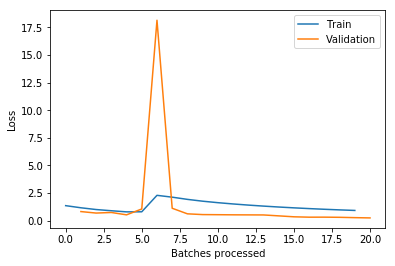

In [31]:
learn.recorder.plot_losses()

In [32]:
learn.load("best-stage1");

In [33]:
learn.unfreeze()

In [34]:
lrs = slice(lr/1000,lr/10)

In [35]:
learn.fit_one_cycle(cyc_len = 12,
                    max_lr = lrs,
                    pct_start = 0.8,
                    callbacks =[SaveModelCallback(
                        learn,
                        every='improvement',
                        monitor = 'dice',
                        name='best-stage2')])

epoch,train_loss,valid_loss,dice,time
0,0.140929,0.220415,0.892912,00:09
1,0.141466,0.194998,0.917324,00:09
2,0.139344,0.170207,0.944476,00:09
3,0.136991,0.150633,0.959285,00:09
4,0.134592,0.136503,0.959813,00:10
5,0.131787,0.125986,0.956522,00:09
6,0.128077,0.106859,0.963203,00:09
7,0.124152,0.084102,0.969752,00:09
8,0.120042,0.075147,0.969429,00:10
9,0.115224,0.076156,0.965806,00:09


Better model found at epoch 0 with dice value: 0.8929119110107422.
Better model found at epoch 1 with dice value: 0.9173240065574646.
Better model found at epoch 2 with dice value: 0.9444757103919983.
Better model found at epoch 3 with dice value: 0.9592845439910889.
Better model found at epoch 4 with dice value: 0.9598129391670227.
Better model found at epoch 6 with dice value: 0.9632031917572021.
Better model found at epoch 7 with dice value: 0.969752311706543.
Better model found at epoch 10 with dice value: 0.9740610122680664.
Better model found at epoch 11 with dice value: 0.9743447303771973.


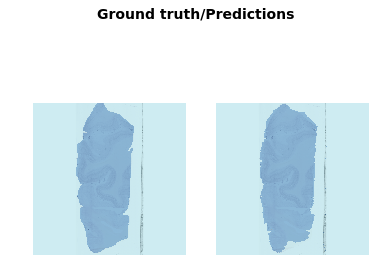

In [50]:
learn.show_results(rows=1, figsize=(6,4))

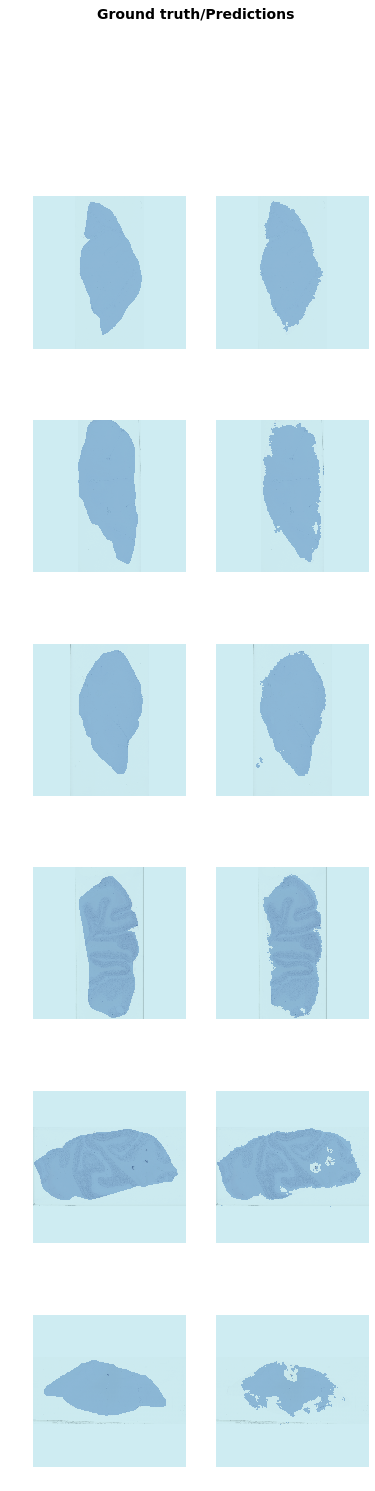

In [53]:
learn.show_results(ds_type=DatasetType.Train, rows=6, figsize=(6,4*6))